In [ ]:
import numpy as np 
import pandas as pd 

import random as rn

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold 
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, auc

from scipy.stats import uniform
import sklearn.ensemble
import itertools

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

from keras.utils.np_utils import to_categorical
from keras.utils import np_utils

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, MaxPool2D, Conv1D
from keras.layers import AvgPool2D, BatchNormalization, Reshape
from keras.optimizers import Adadelta, RMSprop, Adam
from keras.losses import categorical_crossentropy
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

import tensorflow as tf

import os


Using TensorFlow backend.


In [1]:

data = pd.read_csv('train.csv')
print(data.shape)

data= data.drop("PassengerId", axis=1)
data= data.drop("Ticket", axis=1)


data.head(5)

NameError: name 'pd' is not defined

In [3]:
print(data.isnull().sum())

print(data.describe())

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Cabin       687
Embarked      2
dtype: int64
         Survived      Pclass         Age       SibSp       Parch        Fare
count  891.000000  891.000000  714.000000  891.000000  891.000000  891.000000
mean     0.383838    2.308642   29.699118    0.523008    0.381594   32.204208
std      0.486592    0.836071   14.526497    1.102743    0.806057   49.693429
min      0.000000    1.000000    0.420000    0.000000    0.000000    0.000000
25%      0.000000    2.000000   20.125000    0.000000    0.000000    7.910400
50%      0.000000    3.000000   28.000000    0.000000    0.000000   14.454200
75%      1.000000    3.000000   38.000000    1.000000    0.000000   31.000000
max      1.000000    3.000000   80.000000    8.000000    6.000000  512.329200


3    491
1    216
2    184
Name: Pclass, dtype: int64


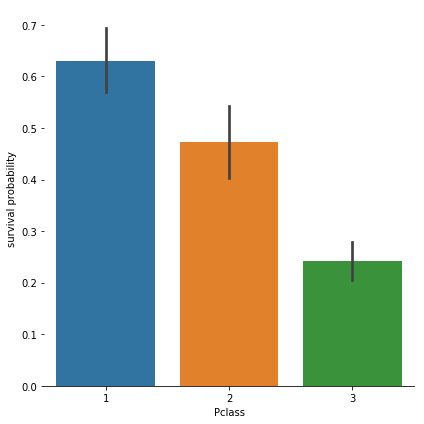

In [4]:
# Explore Pclass vs Survived
g = sns.factorplot(x="Pclass",y="Survived",data=data,kind="bar", size = 6 )
g.despine(left=True)
g = g.set_ylabels("survival probability")


print(data['Pclass'].value_counts())



#### Most common is 3, therefore replace NA with 3. the higher the class (smaller number), the higher the probability of survival.

Mr      558
Ms      185
Mrs     126
Rare     22
Name: Title, dtype: int64


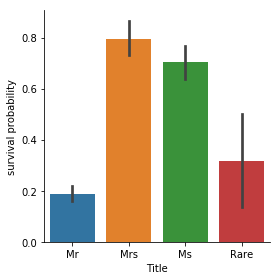

In [5]:
# Get Title from Name
dataset_title = [i.split(",")[1].split(".")[0].strip() for i in data["Name"]]
data["Title"] = pd.Series(dataset_title)



#merge similiar titles
data["Title"] = data["Title"].replace(['Miss', 'Mlle'], 'Ms')
data["Title"] = data["Title"].replace(['Mme', 'Mlle'], 'Mrs')
data["Title"] = data["Title"].replace(['Master', 'Sir'], 'Mr')
data["Title"] = data["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

print(data['Title'].value_counts())

g = sns.factorplot(x="Title",y="Survived",data=data,kind="bar")
# g = g.set_xticklabels(["Ms","Mr","Mr","Rare"])
g = g.set_ylabels("survival probability")

data['Title'].replace( 'Ms',0,inplace=True)
data['Title'].replace( 'Mr',1,inplace=True)
data['Title'].replace( 'Mrs',2,inplace=True)
data['Title'].replace( 'Rare',3,inplace=True)

data= data.drop("Name", axis=1)



#### Most common is Mr, therefore replace NA with Mr. most of the surviors were women.

male      577
female    314
Name: Sex, dtype: int64


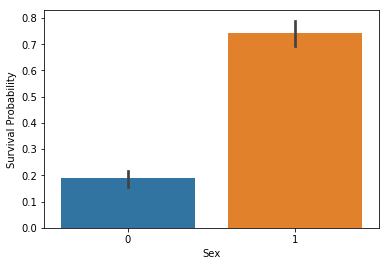

In [6]:
print(data['Sex'].value_counts())

data['Sex'].replace( 'female',1,inplace=True)
data['Sex'].replace( 'male',0,inplace=True)

g = sns.barplot(x="Sex",y="Survived",data=data)
g = g.set_ylabel("Survival Probability")

#### Most common is Male, therefore replace NA with Male. most of the surviors were women.

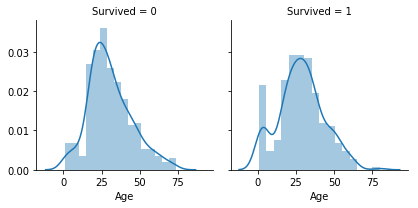

In [7]:
# Explore Age vs Survived
g = sns.FacetGrid(data, col='Survived')
g = g.map(sns.distplot, "Age")

ages = dict([(n, int(0)) for n in range(0, 18)] +
            [(n, int(1)) for n in range(18, 35)] +
            [(n, int(2)) for n in range(35, 50)] +
            [(n, int(3)) for n in range(50, 70)] +
            [(n, int(4)) for n in range(70, 1000)] )
data['Age'] = data['Age'].apply(ages.get)

# g = sns.FacetGrid(data, col='Survived')
# g = g.map(sns.distplot, "Age")

# meanAge= data[['Age']].mean()
# print(meanAge)

data["Age"] = data["Age"].fillna(data["Age"].median())


0 6


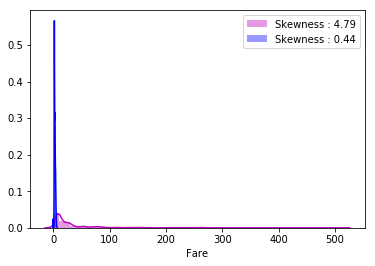

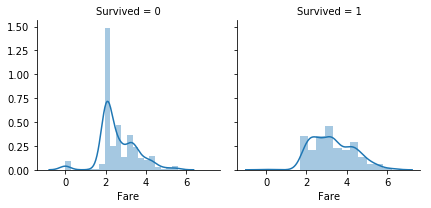

In [8]:
#Fill Fare missing values with the median value
data["Fare"] = data["Fare"].fillna(data["Fare"].median())


g = sns.distplot(data["Fare"], color="m", label="Skewness : %.2f"%(data["Fare"].skew()))
g = g.legend(loc="best")

data["Fare"] = data["Fare"].map(lambda i: np.log(i) if i > 0 else 0)
g = sns.distplot(data["Fare"], color="b", label="Skewness : %.2f"%(data["Fare"].skew()))
g = g.legend(loc="best")


g = sns.FacetGrid(data, col='Survived')
g = g.map(sns.distplot, "Fare")
data["Fare"] = data["Fare"].astype(int)

print(data["Fare"].min(),data["Fare"].max())
fares = dict([(n, int(0)) for n in range(0, 2)] +
            [(n, int(1)) for n in range(2, 4)] +
            [(n, int(2)) for n in range(4,7)] )
data['Fare'] = data['Fare'].apply(fares.get)



In [9]:
data['Embarked'].replace( 'S',0,inplace=True)
data['Embarked'].replace( 'C',1,inplace=True)
data['Embarked'].replace( 'Q',2,inplace=True)

print(data['Embarked'].value_counts())
data["Embarked"] = data["Embarked"].fillna(0)

0.0    644
1.0    168
2.0     77
Name: Embarked, dtype: int64


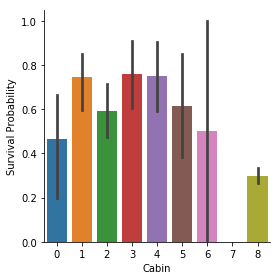

In [10]:
# Replace the Cabin number by the type of cabin 'X' if not
data["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in data['Cabin'] ])


data['Cabin'].replace( 'A',0,inplace=True)
data['Cabin'].replace( 'B',1,inplace=True)
data['Cabin'].replace( 'C',2,inplace=True)
data['Cabin'].replace( 'D',3,inplace=True)
data['Cabin'].replace( 'E',4,inplace=True)
data['Cabin'].replace( 'F',5,inplace=True)
data['Cabin'].replace( 'G',6,inplace=True)
data['Cabin'].replace( 'T',7,inplace=True)
data['Cabin'].replace( 'X',8,inplace=True)

g = sns.factorplot(y="Survived",x="Cabin",data=data,kind="bar")
g = g.set_ylabels("Survival Probability")




In [11]:
print(data.isnull().sum())

X= data.iloc[:,1:]
y= data.iloc[:,0] 


#standardize my data
sc = StandardScaler()
X = sc.fit_transform(X)

#split into training and tessting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

data.head(10)

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Cabin       0
Embarked    0
Title       0
dtype: int64


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title
0,0,3,0,1.0,1,0,0,8,0.0,1
1,1,1,1,2.0,1,0,2,2,1.0,2
2,1,3,1,1.0,0,0,1,8,0.0,0
3,1,1,1,2.0,1,0,1,2,0.0,2
4,0,3,0,2.0,0,0,1,8,0.0,1
5,0,3,0,1.0,0,0,1,8,2.0,1
6,0,1,0,3.0,0,0,1,4,0.0,1
7,0,3,0,0.0,3,1,1,8,0.0,1
8,1,3,1,1.0,0,2,1,8,0.0,2
9,1,2,1,0.0,1,0,1,8,1.0,2


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title
Survived,1.000000,-0.338481,0.543351,-0.027290,-0.035322,0.081629,0.301522,-0.301116,0.106811,-0.035334
Pclass,-0.338481,1.000000,-0.131900,-0.366260,0.083081,0.018443,-0.510905,0.746616,0.045702,-0.157349
Sex,0.543351,-0.131900,1.000000,-0.060213,0.114631,0.245489,0.254116,-0.123076,0.116569,-0.167564
Age,-0.027290,-0.366260,-0.060213,1.000000,-0.212012,-0.120070,0.140070,-0.271204,-0.058527,0.304325
SibSp,-0.035322,0.083081,0.114631,-0.212012,1.000000,0.414838,0.206737,0.041540,-0.059961,-0.032203
Parch,0.081629,0.018443,0.245489,-0.120070,0.414838,1.000000,0.176787,-0.032548,-0.078665,0.028580
Fare,0.301522,-0.510905,0.254116,0.140070,0.206737,0.176787,1.000000,-0.475932,0.026230,-0.000136
Cabin,-0.301116,0.746616,-0.123076,-0.271204,0.041540,-0.032548,-0.475932,1.000000,-0.034887,-0.079990
Embarked,0.106811,0.045702,0.116569,-0.058527,-0.059961,-0.078665,0.026230,-0.034887,1.000000,-0.117721
Title,-0.035334,-0.157349,-0.167564,0.304325,-0.032203,0.028580,-0.000136,-0.079990,-0.117721,1.000000


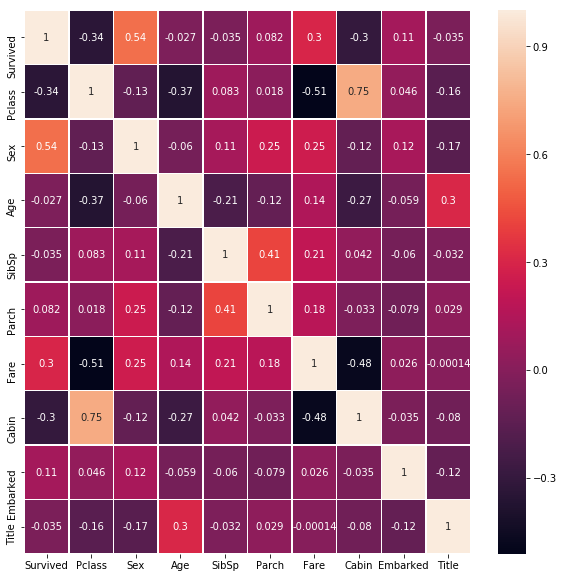

In [12]:
fig, ax = plt.subplots(figsize=(10,10))  
sns.heatmap(data.corr(), annot=True, linewidths=.5, ax=ax)

data.corr()


#### Multiple Models

In [13]:
from sklearn import ensemble, gaussian_process, linear_model, naive_bayes, svm, neighbors, tree, discriminant_analysis, model_selection

MLA = [
  #  Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),

  #  Gaussian Processes
    gaussian_process.GaussianProcessClassifier(),
    
    #GLM
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    #Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),
        #SVM
    svm.SVC(probability=True),
    svm.NuSVC(probability=True),
    svm.LinearSVC(),
    
    #Trees    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    #Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),

    
#     #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
#     XGBClassifier()    
    ]



#split dataset in cross-validation with this splitter class:
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .33, train_size = .66, random_state = 0 ) 

#create table to compare MLA metrics
MLA_columns = ['MLA Name', 'MLA Parameters','MLA Train Accuracy Mean', 'MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD' ,'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)

#create table to compare MLA predictions
MLA_predict = data.iloc[:,0]

#index through MLA and save performance to table
row_index = 0
for alg in MLA:

    #set name and parameters
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
    
    #score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
    cv_results = model_selection.cross_validate(alg, data.iloc[:,1:], data.iloc[:,0], cv  = cv_split)

    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()   
    #if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, should statistically capture 99.7% of the subsets
    MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3   #let's know the worst that can happen!
    

    #save MLA predictions - see section 6 for usage
    alg.fit(data.iloc[:,1:], data.iloc[:,0])
    MLA_predict[MLA_name] = alg.predict(data.iloc[:,1:])
    row_index+=1

    
#print and sort table: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html
MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
MLA_compare
#MLA_predict

E:\py\envs\tf-keras\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
E:\py\envs\tf-keras\lib\site-packages\ipykernel_launcher.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
E:\py\envs\tf-keras\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
E:\py\envs\tf-keras\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training 

E:\py\envs\tf-keras\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
E:\py\envs\tf-keras\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
E:\py\envs\tf-keras\lib\site-packages\skle

E:\py\envs\tf-keras\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
E:\py\envs\tf-keras\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
E:\py\envs\tf-keras\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
E:\py\envs\tf-keras\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You 

,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time
3,GradientBoostingClassifier,"{'min_weight_fraction_leaf': 0.0, 'min_impurit...",0.862245,0.80339,0.0483452,0.0724516
14,SVC,"{'verbose': False, 'gamma': 'auto', 'kernel': ...",0.834184,0.801356,0.0452971,0.0442327
15,NuSVC,"{'verbose': False, 'gamma': 'auto', 'kernel': ...",0.832653,0.798983,0.0485693,0.049438
16,LinearSVC,"{'verbose': 0, 'dual': True, 'penalty': 'l2', ...",0.802891,0.797966,0.0577427,0.0315215
5,GaussianProcessClassifier,"{'max_iter_predict': 100, 'copy_X_train': True...",0.87398,0.797627,0.0540133,0.201143
19,LinearDiscriminantAnalysis,"{'shrinkage': None, 'store_covariance': False,...",0.803231,0.796949,0.0550375,0.00209982
6,LogisticRegressionCV,"{'verbose': 0, 'penalty': 'l2', 'fit_intercept...",0.803912,0.796949,0.0634188,0.104778
8,RidgeClassifierCV,"{'scoring': None, 'fit_intercept': True, 'alph...",0.803741,0.796271,0.0535132,0.00260015
4,RandomForestClassifier,"{'min_weight_fraction_leaf': 0.0, 'min_impurit...",0.89949,0.794915,0.0457627,0.0166115
0,AdaBoostClassifier,"{'random_state': None, 'algorithm': 'SAMME.R',...",0.817007,0.792203,0.0419422,0.0779564


## PARAMETERS FINETUNING
## GradientBoostingClassifier

In [14]:
# cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .33, train_size = .66, random_state = 0 ) 
# cv_results = model_selection.cross_validate(ensemble.GradientBoostingClassifier(), data.iloc[:,1:], data.iloc[:,0], cv  = cv_split)
# GBC=ensemble.GradientBoostingClassifier().fit(data.iloc[:,1:], data.iloc[:,0])

#base model
GBC = ensemble.GradientBoostingClassifier()
base_results = model_selection.cross_validate(GBC, data.iloc[:,1:], data.iloc[:,0], cv  = cv_split)
GBC.fit(data.iloc[:,1:], data.iloc[:,0])

print('BEFORE DT Parameters: ', GBC.get_params())
print("BEFORE DT Training w/bin score mean: {:.2f}". format(base_results['train_score'].mean()*100)) 
print("BEFORE DT Test w/bin score mean: {:.2f}". format(base_results['test_score'].mean()*100))
print('-'*10)



BEFORE DT Parameters:  {'min_weight_fraction_leaf': 0.0, 'min_impurity_decrease': 0.0, 'loss': 'deviance', 'max_leaf_nodes': None, 'init': None, 'verbose': 0, 'max_features': None, 'min_samples_leaf': 1, 'subsample': 1.0, 'min_samples_split': 2, 'random_state': None, 'presort': 'auto', 'max_depth': 3, 'min_impurity_split': None, 'warm_start': False, 'n_estimators': 100, 'criterion': 'friedman_mse', 'learning_rate': 0.1}
BEFORE DT Training w/bin score mean: 86.22
BEFORE DT Test w/bin score mean: 80.31
----------


E:\py\envs\tf-keras\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


### Learning rate
#### optimum: 0.25

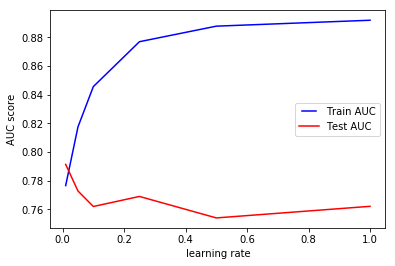

[0.7620238095238094, 0.7539285714285713, 0.7689285714285714, 0.761904761904762, 0.7727380952380953, 0.7913095238095239]


In [15]:
learning_rates = [1, 0.5, 0.25, 0.1, 0.05, 0.01]
train_results = []
test_results = []
for eta in learning_rates:
    model = ensemble.GradientBoostingClassifier(learning_rate=eta)
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = model.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(learning_rates, train_results, 'b', label="Train AUC")
line2, = plt.plot(learning_rates, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("learning rate")
plt.show()

print(test_results)

### N-Estimators
#### optimum: 300

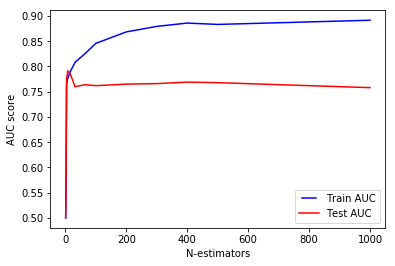

[0.5, 0.53, 0.7761904761904761, 0.7913095238095239, 0.7854761904761904, 0.7597619047619047, 0.7638095238095239, 0.761904761904762, 0.765, 0.7659523809523809, 0.7689285714285714, 0.7678571428571428, 0.7579761904761904]


In [16]:
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200,300,400,500,1000]
train_results = []
test_results = []
for eta in n_estimators:
    model = ensemble.GradientBoostingClassifier(n_estimators=eta)
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = model.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, 'b', label="Train AUC")
line2, = plt.plot(n_estimators, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("N-estimators")
plt.show()

print(test_results)

### Max Depth
#### optimum: no optimum it causes over fitting

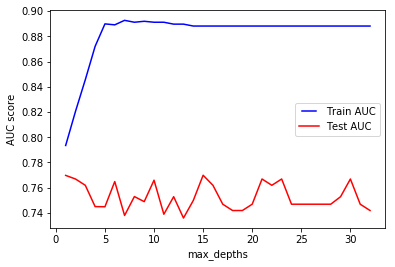

[0.7697619047619048, 0.766904761904762, 0.761904761904762, 0.745, 0.7448809523809523, 0.7648809523809523, 0.7379761904761905, 0.7529761904761904, 0.7489285714285713, 0.7659523809523809, 0.7389285714285714, 0.7528571428571429, 0.7359523809523809, 0.7498809523809524, 0.7698809523809524, 0.761904761904762, 0.7469047619047618, 0.7419047619047618, 0.7419047619047618, 0.7469047619047618, 0.766904761904762, 0.761904761904762, 0.766904761904762, 0.7469047619047618, 0.7469047619047618, 0.7469047619047618, 0.7469047619047618, 0.7469047619047618, 0.7528571428571429, 0.766904761904762, 0.7469047619047618, 0.7419047619047618]


In [17]:
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for eta in max_depths:
    model = ensemble.GradientBoostingClassifier(max_depth=eta)
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = model.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_depths, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("max_depths")
plt.show()

print(test_results)

### Min Samples Splits
#### optimum: 0.0000001, increasing this value results in underfitting

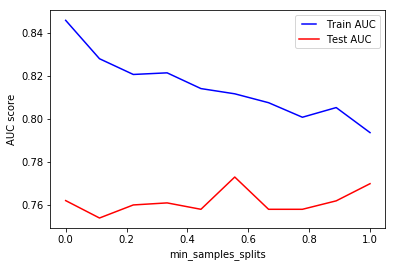

[0.761904761904762, 0.7538095238095239, 0.7598809523809523, 0.7608333333333333, 0.7578571428571428, 0.7728571428571428, 0.7578571428571428, 0.7578571428571428, 0.7617857142857143, 0.7697619047619048]


In [18]:
min_samples_splits = np.linspace(0.0000001, 1.0, 10, endpoint=True)
train_results = []
test_results = []
for eta in min_samples_splits:
    model = ensemble.GradientBoostingClassifier(min_samples_split=eta)
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = model.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_splits, train_results, 'b', label="Train AUC")
line2, = plt.plot(min_samples_splits, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("min_samples_splits")
plt.show()

print(test_results)

### Min Samples Splits
#### optimum: 0.1, increasing this value results in underfitting

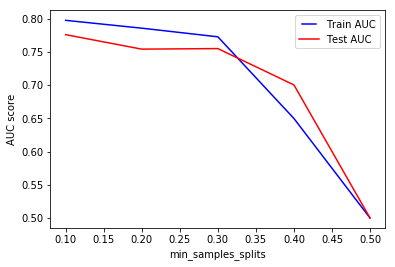

[0.7757142857142857, 0.7539285714285713, 0.7547619047619047, 0.7001190476190478, 0.5]


In [19]:
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
train_results = []
test_results = []
for eta in min_samples_leafs:
    model = ensemble.GradientBoostingClassifier(min_samples_leaf=eta)
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = model.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_leafs, train_results, 'b', label="Train AUC")
line2, = plt.plot(min_samples_leafs, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("min_samples_splits")
plt.show()

print(test_results)

### Max Features
#### optimum: 1

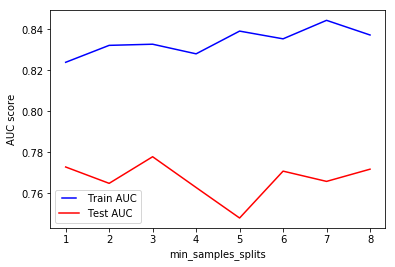

[0.7728571428571428, 0.7648809523809523, 0.7778571428571429, 0.7628571428571429, 0.7479761904761905, 0.7708333333333333, 0.7658333333333334, 0.7717857142857143]


In [20]:
max_features = list(range(1,X_train.shape[1]))
train_results = []
test_results = []
for eta in max_features:
    model = ensemble.GradientBoostingClassifier(max_features=eta)
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = model.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_features, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_features, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("min_samples_splits")
plt.show()

print(test_results)

In [21]:


GBC = ensemble.GradientBoostingClassifier(learning_rate=0.25,n_estimators=300,min_samples_leaf=0.1,
                                         max_features=1, random_state=7)
base_results = model_selection.cross_validate(GBC, data.iloc[:,1:], data.iloc[:,0], cv  = cv_split)
GBC.fit(data.iloc[:,1:], data.iloc[:,0])

print('AFTER DT Parameters: ', GBC.get_params())
print("AFTER DT Training w/bin score mean: {:.2f}". format(base_results['train_score'].mean()*100)) 
print("AFTER DT Test w/bin score mean: {:.2f}". format(base_results['test_score'].mean()*100))

AFTER DT Parameters:  {'min_weight_fraction_leaf': 0.0, 'min_impurity_decrease': 0.0, 'loss': 'deviance', 'max_leaf_nodes': None, 'init': None, 'verbose': 0, 'max_features': 1, 'min_samples_leaf': 0.1, 'subsample': 1.0, 'min_samples_split': 2, 'random_state': 7, 'presort': 'auto', 'max_depth': 3, 'min_impurity_split': None, 'warm_start': False, 'n_estimators': 300, 'criterion': 'friedman_mse', 'learning_rate': 0.25}
AFTER DT Training w/bin score mean: 83.74
AFTER DT Test w/bin score mean: 80.61


E:\py\envs\tf-keras\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [22]:
# import sklearn.feature_selection as feature_selection
# #feature selection
# GBC_rfe = feature_selection.RFECV(GBC, step = 1, scoring = 'accuracy', cv = cv_split)
# GBC_rfe.fit(data.iloc[:,1:], data.iloc[:,0])

# X_rfe = data[data.iloc[:,1:]].columns.values[GBC_rfe.get_support()]
# rfe_results = model_selection.cross_validate(GBC_rfe, data[X_rfe], data[:,0], cv  = cv_split)

# print("AFTER DT RFE Training w/bin score mean: {:.2f}". format(rfe_results['train_score'].mean()*100)) 
# print("AFTER DT RFE Test w/bin score mean: {:.2f}". format(rfe_results['test_score'].mean()*100))

## PARAMETERS FINETUNING
## DecisionTreeClassifier

In [23]:
#base model
DTREE = tree.DecisionTreeClassifier(random_state = 0)
base_results = model_selection.cross_validate(DTREE, data.iloc[:,1:], data.iloc[:,0], cv  = cv_split)
DTREE.fit(data.iloc[:,1:], data.iloc[:,0])

print('BEFORE DT Parameters: ', DTREE.get_params())
print("BEFORE DT Training w/bin score mean: {:.2f}". format(base_results['train_score'].mean()*100)) 
print("BEFORE DT Test w/bin score mean: {:.2f}". format(base_results['test_score'].mean()*100))
print('-'*10)


BEFORE DT Parameters:  {'min_weight_fraction_leaf': 0.0, 'min_impurity_decrease': 0.0, 'min_samples_split': 2, 'max_leaf_nodes': None, 'splitter': 'best', 'min_samples_leaf': 1, 'max_features': None, 'presort': False, 'random_state': 0, 'max_depth': None, 'min_impurity_split': None, 'class_weight': None, 'criterion': 'gini'}
BEFORE DT Training w/bin score mean: 90.58
BEFORE DT Test w/bin score mean: 78.54
----------


E:\py\envs\tf-keras\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


### Max Depth
#### optimum: 4

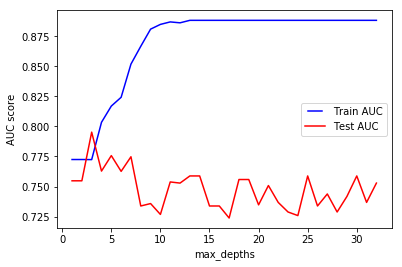

[0.7547619047619047, 0.7547619047619047, 0.7952380952380952, 0.7628571428571429, 0.7757142857142857, 0.7626190476190478, 0.7747619047619048, 0.7338095238095238, 0.7358333333333333, 0.7267857142857144, 0.7538095238095239, 0.7528571428571429, 0.7588095238095238, 0.7588095238095238, 0.7338095238095238, 0.7338095238095238, 0.7238095238095238, 0.7558333333333332, 0.7558333333333332, 0.7347619047619048, 0.7508333333333334, 0.7367857142857143, 0.7288095238095239, 0.7258333333333333, 0.7588095238095238, 0.7338095238095238, 0.7438095238095238, 0.7288095238095239, 0.7417857142857144, 0.7588095238095238, 0.7367857142857143, 0.7528571428571429]


In [24]:
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for eta in max_depths:
    model = tree.DecisionTreeClassifier(max_depth=eta)
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = model.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_depths, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("max_depths")
plt.show()

print(test_results)

In [25]:
class_weight = {0: 1,
                1: 1.45}
DTREE = tree.DecisionTreeClassifier(random_state = 0, max_depth=4, criterion ='entropy', class_weight=class_weight ) 
base_results = model_selection.cross_validate(DTREE, data.iloc[:,1:], data.iloc[:,0], cv  = cv_split)
DTREE.fit(data.iloc[:,1:], data.iloc[:,0])

print('BEFORE DT Parameters: ', DTREE.get_params())
print("BEFORE DT Training w/bin score mean: {:.2f}". format(base_results['train_score'].mean()*100)) 
print("BEFORE DT Test w/bin score mean: {:.2f}". format(base_results['test_score'].mean()*100))
print('-'*10)


BEFORE DT Parameters:  {'min_weight_fraction_leaf': 0.0, 'min_impurity_decrease': 0.0, 'min_samples_split': 2, 'max_leaf_nodes': None, 'splitter': 'best', 'min_samples_leaf': 1, 'max_features': None, 'presort': False, 'random_state': 0, 'max_depth': 4, 'min_impurity_split': None, 'class_weight': {0: 1, 1: 1.45}, 'criterion': 'entropy'}
BEFORE DT Training w/bin score mean: 81.72
BEFORE DT Test w/bin score mean: 79.02
----------


E:\py\envs\tf-keras\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


### CNN

In [26]:
X_train = np.expand_dims(X_train, axis=2)

print(X_train.shape[1:])

(9, 1)


In [27]:
# #setup classifier model

# classifier = Sequential()
# #First Hidden Layer
# classifier.add(Dense(10, activation='relu', kernel_initializer='random_normal',input_dim=6))

# #Middle  Hidden Layer
# classifier.add(Dense(15, activation='relu', kernel_initializer='random_normal'))

# #Output Layer
# classifier.add(Dense(1, activation='sigmoid', kernel_initializer='random_normal'))

model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Conv1D(filters=48, kernel_size=2, activation='relu', input_shape=X_train.shape[1:]))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Conv1D(filters=24, kernel_size=2, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(12, activation='sigmoid', kernel_initializer='random_normal'))
model.add(tf.keras.layers.Dense(24, activation='sigmoid', kernel_initializer='random_normal'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer='random_normal'))

print(model.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 8, 48)             144       
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 48)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 7, 24)             2328      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 3, 24)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 72)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 12)                876       
_________________________________________________________________
dense_2 (Dense)              (None, 24)                312       
__________

In [28]:
model.compile(optimizer ='adam',loss='binary_crossentropy', metrics =['accuracy'])

In [29]:
class_weight = {0: 1,
                1: 1.45}
#model.fit(X_train,y_train, batch_size=10, epochs=250, class_weight=class_weight)


In [30]:
# eval_model=model.evaluate(X_train, y_train)
# eval_model

# print("Training Accuracy: ", eval_model[1]*100, "%")

In [31]:
y_pred=model.predict(np.expand_dims(X_test, axis=2))
y_pred =(y_pred>0.5)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix: ",cm)


print("Testing Accuracy: ", (cm[0][0]+cm[1][1])*100/sum(sum(cm)),"%")

Confusion Matrix:  [[  0 168]
 [  0 100]]
Testing Accuracy:  37.3134328358209 %


In [32]:
data = pd.read_csv('test.csv')

data= data.drop("PassengerId", axis=1)
data= data.drop("Ticket", axis=1)

data["Pclass"] = data["Pclass"].fillna(3)

dataset_title = [i.split(",")[1].split(".")[0].strip() for i in data["Name"]]
data["Title"] = pd.Series(dataset_title)

#merge similiar titles
data["Title"] = data["Title"].replace(['Miss', 'Mlle'], 'Ms')
data["Title"] = data["Title"].replace(['Mme', 'Mlle'], 'Mrs')
data["Title"] = data["Title"].replace(['Master', 'Sir'], 'Mr')
data["Title"] = data["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
data['Title'].replace( 'Ms',0,inplace=True)
data['Title'].replace( 'Mr',1,inplace=True)
data['Title'].replace( 'Mrs',2,inplace=True)
data['Title'].replace( 'Rare',3,inplace=True)

data= data.drop("Name", axis=1)

data['Sex'].replace( 'female',1,inplace=True)
data['Sex'].replace( 'male',0,inplace=True)
data["Sex"] = data["Sex"].fillna(0)

ages = dict([(n, int(0)) for n in range(0, 18)] +
            [(n, int(1)) for n in range(18, 35)] +
            [(n, int(2)) for n in range(35, 50)] +
            [(n, int(3)) for n in range(50, 70)] +
            [(n, int(4)) for n in range(70, 1000)] )
data['Age'] = data['Age'].apply(ages.get)
data["Age"] = data["Age"].fillna(data["Age"].median())

data["Fare"] = data["Fare"].fillna(data["Fare"].median())
data["Fare"] = data["Fare"].map(lambda i: np.log(i) if i > 0 else 0)
data["Fare"] = data["Fare"].astype(int)
fares = dict([(n, int(0)) for n in range(0, 2)] +
            [(n, int(1)) for n in range(2, 4)] +
            [(n, int(2)) for n in range(4,7)] )
data['Fare'] = data['Fare'].apply(fares.get)

data["Embarked"] = data["Embarked"].fillna(0)
data['Embarked'].replace( 'S',0,inplace=True)
data['Embarked'].replace( 'C',1,inplace=True)
data['Embarked'].replace( 'Q',2,inplace=True)

data["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in data['Cabin'] ])
data['Cabin'].replace( 'A',0,inplace=True)
data['Cabin'].replace( 'B',1,inplace=True)
data['Cabin'].replace( 'C',2,inplace=True)
data['Cabin'].replace( 'D',3,inplace=True)
data['Cabin'].replace( 'E',4,inplace=True)
data['Cabin'].replace( 'F',5,inplace=True)
data['Cabin'].replace( 'G',6,inplace=True)
data['Cabin'].replace( 'T',7,inplace=True)
data['Cabin'].replace( 'X',8,inplace=True)



# data = data.fillna(-1)

#standardize my data
# sc = StandardScaler()
# data = sc.fit_transform(data)

# data


In [33]:
# test_pred = model.predict(np.expand_dims(data, axis=2))
# test_pred=(test_pred>0.5).astype(int)

# test_pred = random_forest.predict(data)
# test_pred =(test_pred>0.5).astype(int)

test_pred = GBC.predict(data)
test_pred =(test_pred>0.5).astype(int)


submission = pd.DataFrame()
submission['PassengerId'] = range(892, (len(test_pred)+892))
submission['Survived'] = test_pred

print(submission)

# print(test.shape)

     PassengerId  Survived
0            892         0
1            893         0
2            894         0
3            895         0
4            896         0
5            897         0
6            898         1
7            899         0
8            900         1
9            901         0
10           902         0
11           903         0
12           904         1
13           905         0
14           906         1
15           907         1
16           908         0
17           909         0
18           910         0
19           911         1
20           912         0
21           913         0
22           914         1
23           915         0
24           916         1
25           917         0
26           918         1
27           919         0
28           920         0
29           921         0
..           ...       ...
388         1280         0
389         1281         0
390         1282         0
391         1283         1
392         1284         0
3

In [34]:
submission.to_csv("submission.csv", index=False)